In [89]:
import numpy as np
import copy
import math
import itertools
import matplotlib.pyplot as plt
import collections
import time

def bhattacharyya_dist(sampleDist, PDF):
    coefficient = 0
    tempDist = copy.deepcopy(sampleDist)
    totalSum = np.sum(sampleDist)
    for i in indices:
        tempDist[i] = tempDist[i] / totalSum
    for i in indices:
        coefficient += math.sqrt(tempDist[i]*PDF[i])
    return -math.log(coefficient)
    
def hellinger_dist(sampleDist, PDF):
    coefficient = 0
    tempDist = copy.deepcopy(sampleDist)
    totalSum = np.sum(sampleDist)
    for i in indices:
        tempDist[i] = tempDist[i] / totalSum
    for i in indices:
        coefficient += math.sqrt(tempDist[i]*PDF[i])
    return math.sqrt(1-coefficient)

In [90]:
#Initializing some constants for testing. These constants are used in all of the functions defined, so if you want to use this
#code, set domain, jumpSize, and numJumps the same way they are set here.

domain = [0.05, 1] #1st num is inclusive, 2nd is exclusive
jumpSize = 0.05
numJumps = int((domain[1]-domain[0])/jumpSize)+1
maxWeight = 8000
n=8000
w = np.random.randint(1,20,n)

#This is a function that takes values from the pdf and computes the average deviation from the target distribution
def closeness(distribution, initialDistribution):
    deviation = 0
    tempDistribution = copy.deepcopy(distribution)
    totalSum = np.sum(distribution)
    for i in indices: #make sure size doesn't make issues
        tempDistribution[i] = tempDistribution[i]/totalSum
    #print(sum(distribution))
    for i in indices:
        deviation += (tempDistribution[i] - initialDistribution[i])**2
    return deviation


#For future, use the kolmogorov-smirnov goodness of fit. First of all, we get a probability distribution so use the p-values to
#see how much better our sample does than SRS. Also, kstest in scipy also gives the sample statistic which measures distance.

In [91]:
#Generating random pdfs for testing

def f(a):
    def g(b):
        def h(c):
            def k(d):
                return(abs(0.5*d**a-d**b+0.5*d**c))
            return k
        return h
    return g

p = []

for i in np.random.random(20):
    for j in np.random.random(20):
        for m in np.random.random(20):
            p.append(f(i)(j)(m))
            


In [92]:
#Calculating overall PDF to compare against

PDF = np.zeros((numJumps,))
for func in p:
    for i in range(numJumps):
        PDF[i] += func((i)*jumpSize+domain[0])
totalSum = np.sum(PDF)
for i in range(numJumps):
    PDF[i] = PDF[i] / totalSum

In [93]:
#Recursive helper function to give us all indices so that we can get the values correctly for the multidimensional case.
#You should use this to set a global variable before you need to use it so you only need to call this once. If you call this
#function many times with many dimensions, it will slow down your code a lot.

def nd_range(start, stop, dims):
  if not dims:
    yield ()
    return
  for outer in nd_range(start, stop, dims - 1):
    for inner in range(start, stop):
      yield outer + (inner,)

In [94]:
sampleProportion = 1/5
significanceLevel = 0.9998


"""
This is the version of the problem that works with one-dimensional data.
Feel free to download this notebook and try different values for the above parameters: you will see that in general, barely 
being able to fill up the knapsack (or coming close without quite filling it up) generally leads to the smallest errors. Also,
having a smaller sample will lead to better results as long as you can still fill up the knapsack.
With well chosen parameters, this algorithm will lead to good results both on the fullness metric and on the similarity metric.
"""
m = 1
indices = list(nd_range(0, numJumps, m))
def single_dim_knapsack(w, n, p, maxWeight):
    totalWeight = 0
    currentPDF = np.zeros((numJumps,))
    contents = dict()
    #first, we take a simple random sample that has weight at most maxWeight/2. It should be similar to the population density.
    while True:
        i = np.random.randint(0,n)
        if i not in contents:
            if totalWeight + w[i] > maxWeight*sampleProportion:
                break
            else:
                contents[i] = 1
                totalWeight += w[i]
                totalSum = 0
                for j in range(numJumps):
                    totalSum += p[i](jumpSize*j+domain[0])
                for j in range(numJumps):
                    currentPDF[j] += w[i]*(p[i](jumpSize*j+domain[0]))/totalSum
    #Now, we add objects to this sample to try to correct it and make it closer to the population density
    
    
    #This is the approach that adds 1 object at a time. This time, we just take anything that's significantly better
    currentDeviation = hellinger_dist(currentPDF, PDF)
    pairAdded = True
    numIts=0
    while pairAdded:
        counter = 0
        for i, weight in enumerate(w):
            if i not in contents and totalWeight+w[i] <= maxWeight:
                tempPDF = copy.deepcopy(currentPDF)
                totalSum = 0
                for j in range(numJumps):
                    totalSum += p[i](jumpSize*j+domain[0])
                for j in range(numJumps):
                    tempPDF[j] += w[i]*(p[i](jumpSize*j+domain[0]))/totalSum
                tempDeviation = hellinger_dist(tempPDF, PDF)
                if tempDeviation <= (significanceLevel)*currentDeviation:
                    currentDeviation = tempDeviation
                    totalWeight += w[i]
                    contents[i] = 1
                    currentPDF = tempPDF
                    counter += 1
                    if totalWeight == maxWeight:
                        return contents, currentDeviation, currentPDF, totalWeight, numIts
        if counter == 0:
            pairAdded = False
        numIts += 1
    
    
    return contents, currentDeviation, currentPDF, totalWeight, numIts

In [95]:
start_time = time.time()
a0, b0, c0, d0, e0 = single_dim_knapsack(w, n, p, maxWeight)
timeTaken = time.time() - start_time
print(timeTaken)

18.27551507949829


In [96]:
totalSum = np.sum(c0)
for i in range(numJumps):
    c0[i] = c0[i] / totalSum

In [97]:
hellinger_dist(c0, PDF)

0.00011600217440319529

In [98]:
bhattacharyya_dist(c0, PDF)

1.3456504556808095e-08

In [99]:
d0

6410

In [100]:
closeness(c0, PDF)

8.170597205101226e-09

As you can see, the Bhattacharyya distance is smaller than the hellinger distance. The following graph is a representation of the values of the two distances against the value of the Bhattacharyya coefficient, a measure of similarity between the two distributions. As you can see, the Bhattacharyya distance (blue squares) grows much more slowly than Hellinger distance (red dashes) when the two distributions are very similar (as they are in the case of what our algorithm creates), meaning that the Hellinger distance is a better metric for optimization.

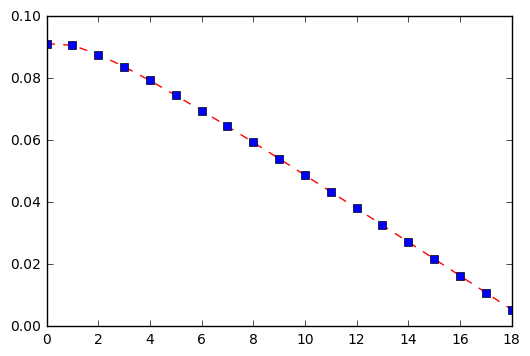

In [102]:
plt.plot(c0, 'r--')
plt.plot(PDF, 'bs')
plt.show()

In the graph above, the blue squares represent the PDF of the function and the red dashes represent the PDF that we computed. They are clearly almost identical, showing that our function creates a sample that has a distribution extremely close to the original population.

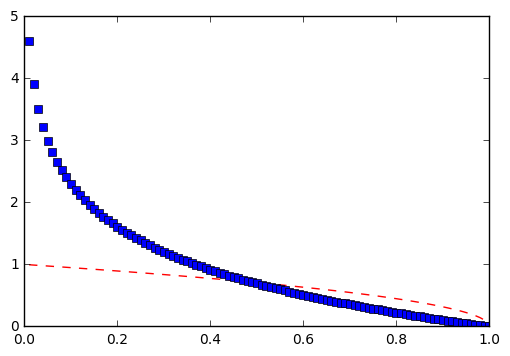

In [21]:
x = np.arange(0.01, 1.01, 0.01)
y = np.zeros((100,))
for i in range(len(x)):
    y[i] = -math.log(x[i])
plt.plot(x, (1-x)**(1/2), 'r--', x, y, 'bs')
plt.show()

Now, we shall make it multidimensional.
The main difference this time is that each entry in p now contains m dimensions.
We still use the same idea: using jumps to approximate the distribution and then use hellinger distance.
Also, rather than having p be a function, we'll just make it an approximation with the densities.


This algorithm has not yet been tested for accuracy. It shall be edited to work with p being a vector of samples instead of a
vector of pdfs as that will make it significantly easier to use (since most data sets come as samples).

The following cells imports some data from UC Irvine's repository. It takes the 134524 elements and randomly combines them into 10,000 groups, and then runs the multidimensional version on the groups. Each data point has 3 attributes that take values along the real numbers. We thus created bins that are inclusive on the lower bound and exclusive on the upper bound, and by doing so, created a 5x5x5 array for the pdfs that the function uses. It can be seen that the function gives worse results for the 3-d case than the 1-d case and the runtime increases as well, but neither of these decreases in performance is particularly bad. This is because we use a metric (hellinger distance) that can easily be used in higher dimensions.

In [22]:
a = open('multidim-data.txt', 'r')

In [23]:
data = a.readlines()

In [24]:
data = [x.strip('\n') for x in data] 
data = [x.split(',') for x in data] 

In [25]:
for i, asdf in enumerate(data):
    del(asdf[7])
    del(asdf[0:4])

In [26]:
for i in range(len(data)):
    for j in range(len(data[i])):
        data[i][j] = float(data[i][j])

In [27]:
maxX = -float('inf')
maxY = -float('inf')
maxZ = -float('inf')
for i in data:
    if i[0] > maxX:
        maxX = i[0]
    if i[1] > maxY:
        maxY = i[1]
    if i[2] > maxZ:
        maxZ = i[2]
maxValues = np.array([maxX, maxY, maxZ]) + np.array([0.0001, 0.0001, 0.0001])

In [28]:
minX = float('inf')
minY = float('inf')
minZ = float('inf')
for i in data:
    if i[0] < minX:
        minX = i[0]
    if i[1] < minY:
        minY = i[1]
    if i[2] < minZ:
        minZ = i[2]
minValues = np.array([minX, minY, minZ])

In [29]:
print(maxValues, minValues)
numBins = 5
binSize = (maxValues - minValues) / numBins

[ 5.75827347  3.94388185  2.60620461] [-0.27869827 -0.49442777 -2.54360914]


In [30]:
binSize

array([ 1.20739435,  0.88766192,  1.02996275])

In [31]:
bins = list(nd_range(0, numBins, 3))
distributions = np.zeros((10000, 5, 5, 5))
overallPDF = np.zeros((5, 5, 5))
for element in data:
    i = np.random.randint(0,10000)
    xPos = math.floor((element[0]-minValues[0])/binSize[0])
    yPos = math.floor((element[1]-minValues[1])/binSize[1])
    zPos = math.floor((element[2]-minValues[2])/binSize[2])
    distributions[i][xPos][yPos][zPos] += 1
    overallPDF[xPos][yPos][zPos]+=1
weights = np.zeros((10000,))
for i in range(10000):
    weights[i] = np.sum(distributions[i])
overallPDF = overallPDF / np.sum(overallPDF)
for i, split in enumerate(distributions):
    tempSum = np.sum(split)
    distributions[i] = split / tempSum

In [32]:
overallPDF

array([[[  0.00000000e+00,   3.71680890e-05,   2.23008534e-05,
           1.04070649e-04,   3.04778330e-04],
        [  0.00000000e+00,   3.71680890e-05,   1.21167970e-03,
           7.80529868e-04,   8.77166900e-04],
        [  7.43361779e-06,   5.20353246e-05,   2.25981981e-03,
           1.29344950e-03,   1.48672356e-05],
        [  7.43361779e-06,   3.71680890e-05,   6.16990277e-04,
           8.17697957e-04,   1.12990990e-03],
        [  1.48672356e-05,   7.43361779e-06,   4.46017068e-05,
           0.00000000e+00,   4.75751539e-04]],

       [[  0.00000000e+00,   1.63539591e-04,   3.64247272e-04,
           1.78406827e-04,   0.00000000e+00],
        [  0.00000000e+00,   5.79822188e-04,   2.25015611e-02,
           6.19963724e-03,   3.71680890e-05],
        [  7.43361779e-06,   3.49380036e-04,   9.21396925e-02,
           4.09369332e-02,   5.20353246e-05],
        [  0.00000000e+00,   4.98052392e-04,   7.44625494e-02,
           9.66370313e-03,   2.97344712e-05],
        [  0.0000

In [33]:
num = 1000
maxWeight = 10000

In [60]:
sampleProportion = 1/5
significanceLevel = 0.9991
m = 3
indices = list(nd_range(0, numBins, m)) #global variable corresponding to all the indices so we only need to generate them once.
def multi_dim_knapsack(w, n, p, maxWeight, m):
    totalWeight = 0
    currentPDF = np.zeros([numBins for i in range(m)])
    contents = dict()
    #first, we take a simple random sample that has weight at most maxWeight/2. It should be similar to the population density.
    while True:
        i = np.random.randint(0,n)
        if i not in contents:
            if totalWeight + w[i] > maxWeight*sampleProportion:
                break
            else:
                contents[i] = 1
                totalWeight += w[i]
                totalSum = 0
                for k in indices:
                    totalSum += p[i][k]
                for k in indices:
                    currentPDF[k] += w[i]*p[i][k]/totalSum
    #Now, we add objects to this sample to try to correct it and make it closer to the population density
    
    
    #This is the approach that adds 1 object at a time. This time, we just take anything that's significantly better
    currentDeviation = hellinger_dist(currentPDF, overallPDF)
    pairAdded = True
    numIts=0
    while pairAdded:
        counter = 0
        for i, weight in enumerate(w):
            if i not in contents and totalWeight+w[i] <= maxWeight:
                tempPDF = copy.deepcopy(currentPDF)
                totalSum = 0
                for k in indices:
                    totalSum += p[i][k]
                for k in indices:
                    tempPDF[k] += w[i]*p[i][k]/totalSum
                tempDeviation = hellinger_dist(tempPDF, overallPDF)
                if tempDeviation <= (significanceLevel)*currentDeviation:
                    currentDeviation = tempDeviation
                    totalWeight += w[i]
                    contents[i] = 1
                    currentPDF = tempPDF
                    counter += 1
                    if totalWeight == maxWeight:
                        return contents, currentDeviation, currentPDF, totalWeight, numIts
        if counter == 0:
            pairAdded = False
        numIts += 1
    
    
    return contents, currentDeviation, currentPDF, totalWeight, numIts

In [35]:
start_time = time.time()
a1, b1, c1, d1, e1 = multi_dim_knapsack(weights, num, distributions, maxWeight, 3)
time_taken = time.time() - start_time
print(time_taken)

19.198320627212524


In [36]:
b1

0.016229246124619286

In [37]:
d1

9997.0

In [38]:
e1

5

In [39]:
closeness(c1, overallPDF)

2.7311646969713808e-07

In [40]:
bhattacharyya_dist(c1, overallPDF)

0.00026342312259786544

In [48]:
from mpl_toolkits.mplot3d import Axes3D

The following is a comparison of the graphs of the PDF that we generated vs the overall PDF. The x, y, and z coordinates correspond to the location of the point, and the color corresponds to the value of the PDF at that point. In this case, each point corresponds to the bin that contains that point as the vertex closest to the origin.

It can be seen that the graphs are indeed very similar, giving a visual representation of what the distance metrics above suggested.

In [76]:
indices
x = np.zeros((len(indices,)))
for i, triple in enumerate(indices):
    x[i] = triple[0]
y = np.zeros((len(indices,)))
for i, triple in enumerate(indices):
    y[i] = triple[1]
z = np.zeros((len(indices,)))
for i, triple in enumerate(indices):
    z[i] = triple[2]

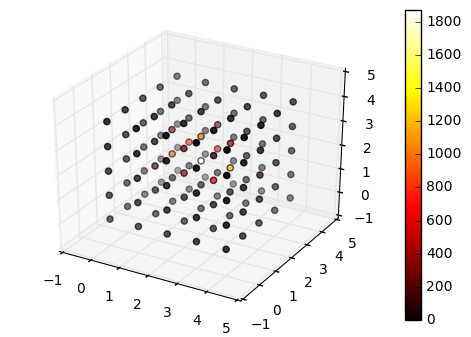

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sp = ax.scatter(x ,y ,z , c=c1.flatten(), cmap = 'hot')
plt.colorbar(sp)
plt.show()

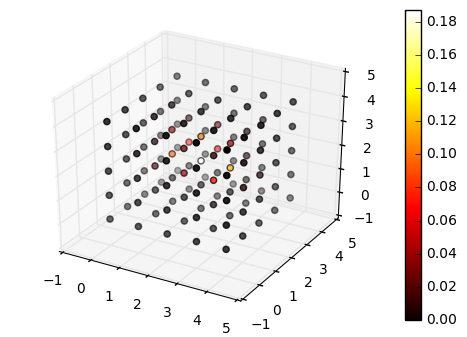

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sp = ax.scatter(x ,y ,z , c=overallPDF.flatten(), cmap = 'hot')
plt.colorbar(sp)
plt.show()